# PEV Household Load Disambiguation: A Simple Approach
Gabriel Konar-Steenberg, NextEra Analytics, May 2019

## Introduction

Load disambiguation is the separation of an electrical load signal into signals for the devices that make it up. Here, we attempt to separate the charging of plug-in electric vehicles (PEVs) from the rest of the loads in a simulated household without knowing what else the household contains. This would allow someone with access to a household's smart meter to determine when the household's PEV was charging without installing any additional equipment. Given that widespread PEV adoption is one of the more feasible ways to achieve sustainable transportation in the future, that the times at which PEVs charge is likely to have a large impact on the grid (and that PEVs could even be used as a network of batteries to stabilize the grid), and that the installation of new equipment makes any PEV charger monitoring or regulation less convenient, it is in the best interest of those working to form a sustainable, stable grid to solve this load disambiguation problem.

Before we begin, it is important to note that there exist valid privacy concerns related to the collection and analysis of household electrical load data, especially as new methods are developed to uncover more information from these signals. In every scenario where load analysis is actually being considered for real-world deployment, the ethical implications should be studied in detail.

## Problem Statement

Our raw data, from https://data.nrel.gov/submissions/69, consists of:
 * Household load data every 10 minutes for 1 year
 * Load profiles of PEVs for 1 year, for two scenarios:
  * Level 1 (L1): charges at 1920 W
  * Level 2 (L2): charges at 6600 W
 * A mapping of vehicles to households

Our ultimate goal is to predict, using a smart meter that reports a household's electrical load every 30 minutes,
 1. How many PEVs that household has
 2. How much electricity the PEVs consume when charging
 3. Whether or not each PEV is charging at a given time

## Overview of Method

Presuming that the households sampled do not have PEVs, we simulate what the load data would look like if the households were to have PEVs. This gives us the input we need to train prediction algorithms that will ultimately fulfil the goal above. We will start with simple statistical algorithms and then, as time permits, move on to more sophisticated techniques.

## Input

The `simulate_data` method in the `get_input.py` file simulates datasets for us. It takes six parameters:
 * `vehicles_L1`: The approximate number of vehicles charging at L1 across the dataset
 * `error_L1`: The uncertainty of `vehicles_L1`
 * `vehicles_L2`: The approximate number of vehicles charging at L2 across the dataset
 * `error_L2`: The uncertainty of `vehicles_L2`
 * `timestep`: How many raw data samples to downsample into one simulated data sample
 * `random_seed` (optional): The random seed to be used in all simulation randomness

and returns a dict of four variables:
 * `combined`: The combination of the EV load and the baseline power consumption. The main input to our future prediction algorithms.
 * `load`: The EV load. Output 1 of our prediction algorithms.
 * `households`: The household-to-vehicle map. Output 2 of our prediction algorithms.
 * `params`: A list of parameters containing approximate numbers of L1 and L2 vehicles, uncertainties for these numbers, and the total number of vehicles.

For now, we assume that the 75% of the total cars are PEVs, that 30% of these charge at L1 and the remaining 60% charge at L2, and that we know the number of L1 and L2 vehicles to 5% uncertainty. We also assume the smart meters give us data every 30 minutes, meaning we set `timestep=3` to combine three of the 10-minute raw samples into each 30-minute simulated sample.

In [1]:
import pandas as pd
n_vehicles = len(pd.read_csv("raw_data/vehicles.csv"))
n_L1 = n_vehicles * 0.75 * 0.3
n_L2 = n_vehicles * 0.75 * 0.6
d_L1 = n_L1*0.05
d_L2 = n_L2*0.05

The `get_data` method automatically takes care of simulating data and storing it so it doesn't have to be re-simulated each time. We simulate two datasets, one with `random_seed=0` for training and the other with `random_seed=1` for testing even though we will later use separate groups of households for training and testing, because if we used the same dataset, prediction algorithms could circumvent the uncertainty we introduce in the number of L1 and L2 vehicles by looking at the number of those vehicles in the training data.

Here's what the simulated input data looks like:

In [2]:
import get_input
from IPython.display import display
data = get_input.get_data(n_L1, d_L1, n_L2, d_L2, 3, 0)
for key in data:
    print(key)
    display(data[key])

combined


,Household 1,Household 2,Household 3,Household 4,Household 5,Household 6,Household 7,Household 8,Household 9,Household 10,...,Household 191,Household 192,Household 193,Household 194,Household 195,Household 196,Household 197,Household 198,Household 199,Household 200
Time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,541.296667,475.540000,1377.033333,440.723333,2043.566667,319.280000,615.260000,869.083333,245.206667,387.316667,...,574.260000,1704.733333,710.270000,513.843333,262.886667,390.353333,275.740000,2126.933333,2109.733333,410.566667
2010-01-01 00:30:00,549.256667,449.853333,1377.030000,321.766667,2556.433333,783.810000,687.570000,845.746667,532.483333,387.313333,...,318.670000,1681.233333,263.600000,632.396667,261.873333,623.746667,511.760000,1937.166667,2228.066667,531.766667
2010-01-01 01:00:00,302.983333,459.343333,886.150000,328.263333,2074.500000,315.943333,679.126667,761.196667,773.606667,625.660000,...,569.483333,1299.666667,266.780000,388.213333,504.043333,359.723333,273.650000,1984.266667,2444.000000,526.040000
2010-01-01 01:30:00,558.503333,905.173333,885.230000,326.140000,1707.500000,299.633333,639.720000,774.286667,516.880000,626.013333,...,560.206667,1227.000000,263.100000,388.000000,261.620000,616.013333,274.553333,2024.000000,2370.533333,528.903333
2010-01-01 02:00:00,303.733333,435.046667,886.140000,555.623333,1784.166667,314.893333,925.186667,520.673333,290.290000,867.693333,...,325.863333,1225.033333,507.666667,388.000000,503.370000,384.013333,268.846667,2003.166667,2397.400000,528.903333
2010-01-01 02:30:00,544.656667,942.670000,886.200000,566.880000,1521.500000,542.340000,685.266667,736.493333,290.286667,620.106667,...,320.730000,1273.500000,505.546667,629.660000,503.876667,609.296667,274.890000,2111.700000,2031.266667,528.900000
2010-01-01 03:00:00,321.823333,448.930000,988.246667,333.833333,1788.100000,320.136667,426.370000,751.940000,292.423333,628.256667,...,332.023333,1371.100000,510.286667,639.706667,264.363333,372.926667,760.936667,2014.666667,4639.872510,537.210000
2010-01-01 03:30:00,551.273333,437.356667,950.093333,333.963333,1952.633333,305.926667,426.953333,538.793333,292.423333,386.756667,...,326.543333,1612.733333,268.286667,398.036667,263.686667,876.486667,720.083333,2211.366667,6019.417260,290.950000
2010-01-01 04:00:00,319.076667,713.966667,1161.986667,811.206667,1700.966667,805.490000,454.670000,561.920000,534.083333,386.943333,...,334.536667,1371.133333,508.276667,639.706667,265.963333,636.420000,945.283333,2249.966667,2848.466667,289.523333


load


,Household 1,Household 2,Household 3,Household 4,Household 5,Household 6,Household 7,Household 8,Household 9,Household 10,...,Household 191,Household 192,Household 193,Household 194,Household 195,Household 196,Household 197,Household 198,Household 199,Household 200
Time,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000
2010-01-01 00:30:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000
2010-01-01 01:00:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000
2010-01-01 01:30:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000
2010-01-01 02:00:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000
2010-01-01 02:30:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000
2010-01-01 03:00:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,2339.472510,0.000000
2010-01-01 03:30:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,3860.283926,0.000000
2010-01-01 04:00:00,0.000000,0,0,0,0,0.000000,0.000000,0,0,0.000000,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0,0,0.000000,0.000000


households


,Household,L1,L2
0,Household 1,0,1
1,Household 2,0,0
2,Household 3,0,0
3,Household 4,0,0
4,Household 5,0,0
5,Household 6,0,1
6,Household 7,1,1
7,Household 8,0,0
8,Household 9,0,0
9,Household 10,0,1


params


0
vehicles_L1        78.300
vehicles_L2       156.600
vehicles_total    348.000
error_L1            3.915
error_L2            7.830
Name: 1, dtype: float64

`simulate_data` also randomizes the beginning and end of each charging period so that these times do not always neatly correspond to 10-minute intervals.

## Output

### `Predictor` Class Structure

To move us towards writing prediction algorithms, we create an abstract `Predictor` class. Each `Predictor` is allowed access to training data consisting of `params`, `combined`, `load`, and `households`, defined above, and should return a dict containing predicted `load` and `households` given test `params` and `combined`. `Predictor`s should also be able to save and load themselves to and from files so that training can be done separately from testing; the implementation of this storage is left to each `Predictor`.

In [3]:
from IPython.core import page
page.page = print

import predictor
#Print the source code of Predictor
%psource predictor.Predictor

class Predictor(ABC):
    @classmethod
    @abstractmethod
    def load(cls, path):
        pass    #Should return a Predictor loaded from the file at path

    @abstractmethod
    def train(self, params, combined, load, households):
        pass    #Should train the Predictor

    @abstractmethod
    def predict(self, params, combined):
        pass    # Should return {"load": loadPrediction, "households": householdPrediction}

    @abstractmethod
    def save(self, path):
        pass    #Should save the Predictor to a file at path



We define a control Predictor, `PredictorZero`, that simply predicts zero for all data:

In [4]:
import predictor_zero
%psource predictor_zero.PredictorZero

class PredictorZero(Predictor):
    def __init__(self):
        pass

    @classmethod
    def load(cls, path):
        return PredictorZero()  #No state to load, so we just return a new one

    def train(self, params, combined, load, households):
        pass    #Nothing to train

    def save(self, path):
        pass    #No state to save

    def predict(self, params, combined):
        load = pd.DataFrame(float(0), index=combined.index, columns=combined.columns)
        households = pd.DataFrame(0, index=combined.columns, columns=["L1", "L2"])
        return {"load": load, "households": households}



### Test Harness

We create a test harness, contained within `evaluate_prediction.py`. It randomly splits the data by household into training and testing data (currently 75% training and 25% testing). To assess model fit, we define a root mean square error ("RMSE") function and a precision and recall ("p&r") function, for which we consider any nonzero output to be a "positive." We calculate these for `load` and `households`.

Here are the test results for `PredictorZero`:

In [5]:
import evaluate_prediction
get_input.verbose = False
train, test = evaluate_prediction.get_train_test(evaluate_prediction.split)
predictorZero = predictor_zero.PredictorZero()
evaluate_prediction.evaluate_prediction(predictorZero, test)

Results for PredictorZero:
	Load RMSE: 		1261.25
	Household RMSE: 	1.015
	Load p&r: 		nan, 0.0
	Household p&r: 		nan, 0.0


(Precision for this `Predictor` is undefined because there are no predicted positives.)

Now we can define some more sophisticated `Predictor`s.

## Models

### `PredictorControlStatistical`

To begin with, we define a basic statistical algorithm called `PredictorControlStatistical` that predicts that the households with the greatest power consumption have PEVs and, for each household, periods of greatest power consumption correspond to charging periods. We use a rough measure of the "spikiness" of the peaks in each household's power signal to determine whether its PEVs are charging at L1 or L2, with an adjustable threshold.

Here is an overview of the algorithm:

Training:
 1. Calculate how many watts each car consumes on average by dividing the total average PEV load by the total number of PEVs.
 2. From this, calcualate how many watt-"blocks" per day each car must charge, where a block is the time between one load reading and the next.
 3. For this model, we will assume that each household has either one, two, or three cars, though not necessarily PEVs. Here, calculate the fraction of households that have one car based on the distribution of PEVs and the fraction of all cars that are PEVs.
 4. Ideally we would iteratively tune the threshold used to decide between L1 and L2, but for now, that is hand-optimized to produce the correct L1:L2 ratio.

Prediction:
 1. Do lots of math to figure out how many households have zero, one, two, and three PEVs.
 2. Divide up the households by power consumption such that those that use the most power have three PEVs, the next set have two, etc., the households that consume the least power have zero PEVs.
 3. For each household:
    1. For each car:
       1. For each day, figure out a threshold for which the sum over every block of all power above the threshold is equal to the power consumed by the number of PEVs the household has been determined to have. Keep track of how many blocks meet this threshold.
       2. If the number of blocks that meet this threshold over the number of PEVs in the household is greater than the threshold from training step 4, the current car is L2.
       3. If the car is L2, it consumes 6600 W each block it is plugged in. If it is L1, it consumes 1920 W.
       4. For each day:
          1. Conclude that the car is charging during the block with the greatest power consumption. (This model ignores the fact that a car may be plugged in part of the way through a block.)
          2. Reduce that block by the power consumption of the car.
          3. Move to the next greatest block and repeat until the charging threshold from training step 2 has been met.

Loading and saving: Simply use pickle.dump(self) and pickle.load.

Let's see how it does:

In [6]:
import predictor_control_statistical
predictorControlStatistical = predictor_control_statistical.PredictorControlStatistical(evaluate_prediction.split, 30)
predictorControlStatistical.train(train["params"], train["combined"], train["load"], train["households"])
evaluate_prediction.evaluate_prediction(predictorControlStatistical, test)

Results for PredictorControlStatistical:
	Load RMSE: 		1300.07
	Household RMSE: 	0.975
	Load p&r: 		0.597, 0.519
	Household p&r: 		0.642, 0.694


Judging by RMSE, we have succeeded in predicting which households have PEVs with more accuracy than the PredictorZero control. However, our load RMSE here is worse than that of PredictorZero. There was a real PEV load 60% of the time we predicted one and we predicted 52% of the PEV load blocks; a household actually had a PEV 60% of the times we predicted it did and we predicted 69% of the households with PEVs.

In the future, one might decide how important precision is versus recall and tune the algorithms to be more liberal or conservative with their predictions to match.

### `PredictorStatisticalDaily`

We now try to improve the accuracy of the statistical predictor by making it aware of trends in electrical load. Our first approach is to keep track of the average load for every block in the training data and then subtract it out of the input, in an attempt to find only the anomalously large load values. We can then simply reuse `PredictorControlStatistical`:

In [15]:
import predictor_statistical_daily
%psource predictor_statistical_daily.PredictorStatisticalDaily

class PredictorStatisticalDaily(Predictor):
    def __init__(self, subset, period):
        self.helper = PredictorControlStatistical(subset, period)
        self.subset = subset
        self.period = period

    @classmethod
    def load(cls, path):
        return pickle.load(open(path, "rb"))

    def train(self, params, combined, load, households):
        baseline_load = combined-load
        self.baselines = baseline_load.mean(axis="columns")
        self.helper.train(params, combined.sub(self.baselines, axis="index"), load, households)    #May have to modify later if PredictorControlStatistical.train gets more complicated
        self.helper.l2_threshold = 3585   #It seems like this threshold should be lower than the one in predictor_control_statistical, so I'm not sure why tuning for the n_L1/n_L2 ratio gets it to be higher.

    def save(self, path):
        pickle.dump(self, open(path, "wb"))

    def predict(self, params, combined):
        return self.helper.predict(params, 

Let's test it:

In [16]:
predictorStatisticalDaily = predictor_statistical_daily.PredictorStatisticalDaily(evaluate_prediction.split, 30)
predictorStatisticalDaily.train(train["params"], train["combined"], train["load"], train["households"])
evaluate_prediction.evaluate_prediction(predictorStatisticalDaily, test)

Results for PredictorStatisticalDaily:
	Load RMSE: 		1330.91
	Household RMSE: 	1.025
	Load p&r: 		0.583, 0.519
	Household p&r: 		0.647, 0.673


The RMSE metrics seem to indicate that this `Predictor` is worse than the naïve statistical one; the precision and recall metrics are very similar between the two algorithms but, overall, are probably also slightly worse for `PredictorStatisticalDaily`. We will now try to analyze why this is the case and hopefully fix it.

### `PredictorStatisticalComposite`

Let's graph a few days of the averaged household load that `PredictorStatisticalDaily` uses as a baseline:

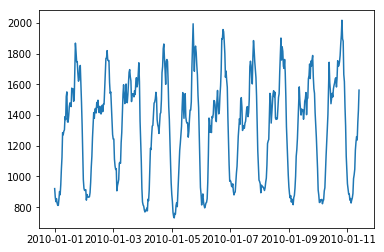

In [14]:
import visualize_output
visualize_output.averages()

It looks very noisy. Perhaps this noise is compounding the noisiness of the signal and adding more peaks, reducing the ability of the statistical algorithm to pick out the charging blocks.

Let's try smoothing the baseline out. We do this in two steps: first, we compute a moving average of the average daily household load across the whole year; second, we find the average household load for each of the 24 hours of the day. We can then average the two curves to form a composite smoothed baseline:

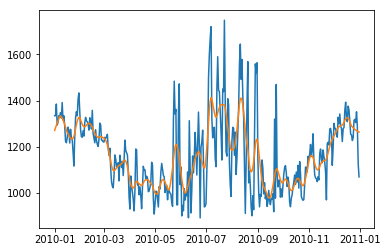

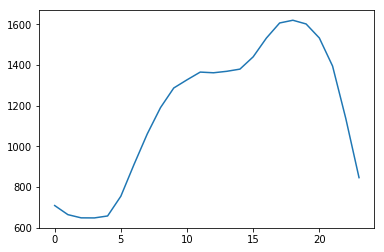

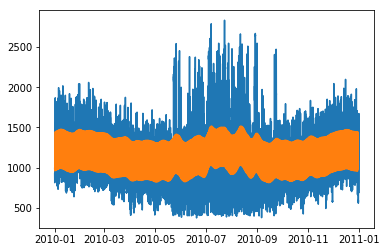

In [10]:
visualize_output.smoothed()

Here, the first figure shows unsmoothed (blue) and seasonally smoothed load (orange), the second shows hourly smoothed load, and the third shows unsmoothed load (blue) and composite smoothed load we have calculated (orange).

Now we can implement another statistical `Predictor`, `PredictorStatisticalComposite`, that uses this composite smoothed load as its baseline.

In [17]:
import predictor_statistical_composite
predictorStatisticalComposite = predictor_statistical_composite.PredictorStatisticalComposite(evaluate_prediction.split, 30)
predictorStatisticalComposite.train(train["params"], train["combined"], train["load"], train["households"])
evaluate_prediction.evaluate_prediction(predictorStatisticalComposite, test)

Results for PredictorStatisticalComposite:
	Load RMSE: 		1318.87
	Household RMSE: 	0.975
	Load p&r: 		0.603, 0.518
	Household p&r: 		0.654, 0.694


We have returned to the same household RMSE as with the naïve statistical prediction and have achieved a load RMSE approximately halfway in between `PredictorControlStatistical` and `PredictorStatisticalDaily`. The precision and recall are both very similar to `PredictorControlStatistical`, perhaps marginally better. Our smoothing seems to have eliminated some of the problems introduced by the noisy baseline in `PredictorStatisticalDaily`, but it is overall not much better than the naïve statistical prediction.

One future step here might be to account for the fact that the daily load curve changes seasonally. In general, the baselines could probably be improved somewhat. For now, however, let's move beyond these statistical methods. We graph a few days of the total load (blue) and load due to PEVs (orange) of a household with one L1 PEV and one L2 PEV:

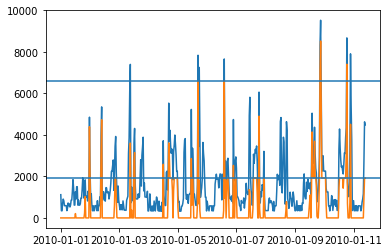

In [12]:
visualize_output.household_with_EVs()

The horizontal lines shown are the L1 and L2 charging rates. Observing that the spikes in load due to PEV charging are very similar in duration (and intensity) to spikes in the load due to other factors, we conclude that a change point algorithm is likely not the best choice. (Using the "ruptures" library, I tried one anyway, in `predictor_change_point`, but cursory efforts did not produce anything useful.)

Another possible approach is to try to detect instances where the load suddenly spikes by an amount that corresponds to one of the charging levels. We analyze a graph of change in load for the household and time period shown above, calculated using several methods:

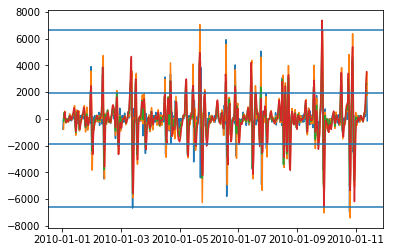

In [13]:
visualize_output.differences()

Here,
 * The blue curve is a simple differences between the load in one time block and the load in the block immediately prior
 * The orange curve is the difference between the load of one block and the load of the block *two* blocks prior
 * The green curve is like the blue curve but using moving averages (of window 2)
 * The red curve is like the orange curve but using moving averages (of window 2)
 * The horizontal lines are the L1 and L2 charging rates and their negatives.

From the graph, it is not immediately apparent that any of the four difference curves can clearly illuminate which load spikes are due to PEV charging and which are not; however, this path merits further exploration. A starting point would be to design an algorithm that considers any load spike within a certain threshold distance of a L1 or L2 charging wattage to be due to a PEV being plugged in.

The next step might be linear algebra-based sparse matrix methods. I looked at these two papers:
 * https://pdfs.semanticscholar.org/9281/320a60a24a18c8fd980331af01d289eda01c.pdf
 * http://papers.nips.cc/paper/4054-energy-disaggregation-via-discriminative-sparse-coding.pdf

and found the sparse methods detailed therein to be beyond what I could comprehend with my current knowledge in the time I had left. This would definitely be something to continue exploring, however.

## Conclusion

My results do not exactly solve the problem of accurately predicting when a PEV is charging based on a household's electrical load goes, though they do demonstrate that it is not a trivial problem. The way forward probably lies in sparse methods or some other sophisticated technique that lies beyond my skill level, at least for now. Throughout this report, I have noted areas for future work. Though my results are not a full solution, hopefully they have some use as a steppingstone towards more accurate results that can help facilitate the adoption of convenient yet privacy-conscious household load analytics, paving the way to PEV charging that works well with the grid.